# $\mathcal{l}_2$ penalty method algorithm

In [23]:
# References

# norms_sqrd(S,X) - max(norms_sqrd(S,X))

# beta = max(norms_sqrd)

# V = s_x_list_norms(S,X)**2 - max(s_x_list_norms(S,X)**2)
# max(0,V[5])

In [24]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import sklearn.datasets
from math import pi, sin, cos

In [25]:
#no. of sensors
FIELDSIZE = 100
#sensor location range
SCALE = 100
#lambda for poisson distr.
LAM = 50

In [26]:
from math import pi, cos, sin
#generate random points on the circumference of a circle
def point(h, k, r):
    theta = random.random() * 2 * pi
    return (h + cos(theta) * r, k + sin(theta) * r)

In [27]:
centers = [point(50,50,50) for _ in range(8)]

In [37]:
#generate a set of sensors, X generated randomly and a random starting point, S
S = np.array([random.random()*SCALE, random.random()*SCALE])

#X uniform
#X = np.array([ [ random.random()*SCALE, random.random()*SCALE ] for i in range(FIELDSIZE) ])

#X Poisson
#X = np.random.poisson(LAM, (FIELDSIZE, 2))

# generate random points on the circumference of a circle
X = np.array([point(50,50,50) for _ in range(100)])

#X blobs
#X = sklearn.datasets.make_blobs(n_samples=FIELDSIZE, centers = centers, cluster_std = 3)
#X = X[0]

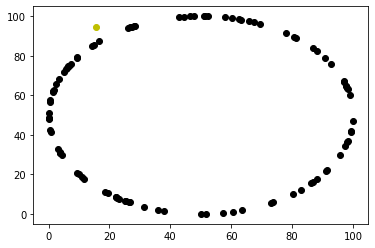

In [38]:
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.show()

In [39]:
def s_x_list(s,x):
    arr1 = []
    for i in range(FIELDSIZE):
        t1 = s - x[i]
        arr1.append(t1)
    return np.array(arr1)

In [40]:
def norms_sqrd(s,x):
    arr1 = []
    for i in range(FIELDSIZE):
        t1 = s - x[i]
        t2 = np.array(t1)
        t3 = np.linalg.norm(t2)**2
        arr1.append(t3)
    return np.array(arr1)

In [41]:
def gradient_function(s,x,k,b):
    N = norms_sqrd(s,x)
    s_minus_x = s_x_list(s,x)
    g_max = []
    if  max(norms_sqrd(s,x)) < b: #update beta if its closer
        b = max(norms_sqrd(s,x))
    for i in range(FIELDSIZE):
        g = N[i] - b
        g_plus = max(0,g)
        g_max.append(s_minus_x[i]*g_plus)
    grad = 2*sum(s_minus_x) + 2*(k**2)*sum(g_max)
    return grad

In [42]:
def GD(s,x,k,b, step): return s - step*gradient_function(s,x,k,b)

In [43]:
def Descent(s,x, EPSILON):
    t_start = time.time()
    s0 = s
#     print('s', s0)
    k=1
    
    beta = max(norms_sqrd(s0,x))
#     print("beta", beta)
    s_list = [s0]
    lam = 1 / np.max( np.linalg.svd( x @ x.T ) [1] ) # approximating Lipschitz constant with SVD (MATLAB ok)
    theta = float(random.getrandbits(128)) # this should essentially be infinity
#     print('lambda', lam)
    lam_list = [round(lam, 5)]

    s1 = GD(s0,x,k,beta,lam)
#     print('s', s1)
    norm_list = [round(np.linalg.norm(gradient_function(s1,x,k,beta)), 3)]
    time_list = [round(time.time() - t_start,5)]
    k=2
    
    while np.linalg.norm(gradient_function(s1,x,k,beta)) > EPSILON:
        t1_start = time.time()
#         print("point distance", np.linalg.norm(s1 - s0))
#         if max(norms_sqrd(s1,x)) < beta:
#             beta = max(norms_sqrd(s1,x))
#         print("beta", beta)
        old_lam = lam
        min1 = np.sqrt(1 + theta)*old_lam
#         print("min1", min1)
        min2 = np.linalg.norm(s1-s0)/(2*np.linalg.norm(gradient_function(s1, x, k, beta) - gradient_function(s0, x, k, beta) ))
#         print("min2", min2)
        lam = np.min([min1, min2])
#         print('lambda', lam)
        theta = lam/old_lam
        s0 = s1
        s1 = GD(s0, x, k, beta, lam )
#         print('s', s1)
        s_list.append(s1)
    
        #add lam to lam_list
        lam_list.append(round(lam, 5))
        
        #add norm of grad to norm_list
        norm_list.append(round(np.linalg.norm(gradient_function(s1,x,k,beta)), 4))
        k+=1
        t1_end = time.time()
        
        #add calctime of iteration to time_list
        iter_time = t1_end - t1_start
        time_list.append(round(iter_time, 5))
        
    t_end = time.time()
    #calculate total time of program
    duration = [t_end-t_start]
    
    return np.array([s_list, norm_list, lam_list, time_list])

In [44]:
import pandas as pd

In [45]:
TEST = Descent(S,X,1e-6)

<ipython-input-43-32886d49c326>:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list, norm_list, lam_list, time_list])


In [46]:
#test0: x-coords of each step
#test1: y-coords of each step
test0 = [round(TEST[0][i][0], 3) for i in range(len(TEST[0]))]
test1 = [round(TEST[0][i][1], 3) for i in range(len(TEST[0]))]

coords = list(zip(test0, test1))

testPD = pd.DataFrame({'coords': coords, 'norm':TEST[1], 'lambda':TEST[2], 'iter_time':TEST[3]})

testPD.head(10)

testPD.to_csv('tables/circle.txt',
              sep = '&'
)

In [47]:
#x0 = [X[i][0] for i in range(FIELDSIZE)]
#x1 = [X[i][1] for i in range(FIELDSIZE)]
#plt.scatter(x0,x1, c = 'k')
#plt.scatter(test0[0], test1[0], c = 'y')
#plt.plot(test0, test1, c = 'y')
#plt.scatter(test0[-1], test1[-1], c = 'y')
#plt.show()

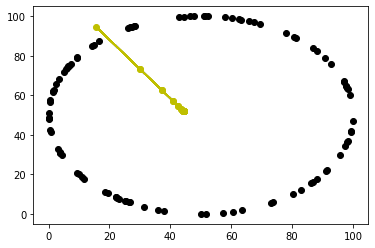

In [48]:
#Plot scatter plot of sensors
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]

#Plot each step k
plt.scatter(x0,x1, c = 'k')
for i in range(len(test0)-1):
    

    plt.scatter(test0[i], test1[i], c = 'y')
    plt.plot(test0, test1, c = 'y')
    plt.scatter(test0[i+1], test1[i+1], c = 'y')
    i+=1
plt.show()

In [49]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator